# Deep Reinforcement Learning Coursework
### Alessandro Alviani - alessandro.alviani@city.ac.uk
### Dimitrios Megkos - dimitrios.megkos@city.ac.uk
### Part 2: Deep Q-Learning
#### OpenAI Gym: Lunar Lander

OpenAI description: Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

#### Import Libraries

In [3]:
# General imports
from itertools import count
# PyTorch import
import torch
import torch.optim as optim
import torch.nn.functional as F
# Import custom classes and functions
from deepqlearning_functions import EnvManager, DQN, Experience, extract_tensors, ReplayMemory, EpsilonGreedyValue, DRLAgent, QValues, plot_cma, reward_ma
# Seed for reproducibility
import numpy as np
import matplotlib.pyplot as plt
import random
import os
torch.manual_seed(10)

#### Initialize Parameters

In [5]:
# Set device based on wether there is a GPU or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters for the Environment
# https://gym.openai.com/envs/LunarLander-v2/
env_name = 'LunarLander-v2'
env = EnvManager(env_name, device) # load the environment manager helper

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.001
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.001
num_episodes = 100


# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes

# Parameters for performance metrics
episode_durations = [] # variable to store the duration of each episode
episode_rewards = [] # variable to store rewards of each episode

#### Create Agent and Neural Networks

In [7]:
# Create the Deep Reinforcement Learning agent
agent = DRLAgent(strategy, env.num_actions_available(), device)

# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Create the target network for Double Deep Q-Network
target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for next state's Q-Values
target_net.load_state_dict(policy_net.state_dict()) # copy policy's net parameters to target net
target_net.eval() # set target net to eval so it's weights do not update with back propagation

# choose the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer



# Create the Dueling Deep Q-Network
duel_policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for current state's Q-Values
# Create the target network for Dueling Double Deep Q-Network
duel_target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for next state's Q-Values
duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy dueling policy's net parameters to dueling target net
duel_target_net.eval() # set dueling target net to eval so it's weights do not update with back propagation

# choose the optimizer
duel_optimizer = optim.Adam(params=duel_policy_net.parameters(), lr=lr) # Adam optimizer

#### DQN - Begin Training
The vanilla form of DQN. Uses Experience Replay and one neural network to calculate current and next state's Q-Values.

In [4]:
# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            episode_durations.append(timestep) # append episode duration
            episode_rewards.append(r_metric) # append episode rewards
            break

    # check if agent solved the game   
    #if reward_ma(episode_rewards,100,False) >= 200:
       # break

# close the render window        
#env.close()

#### Plot Performance Metrics

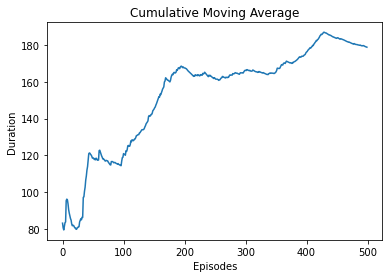

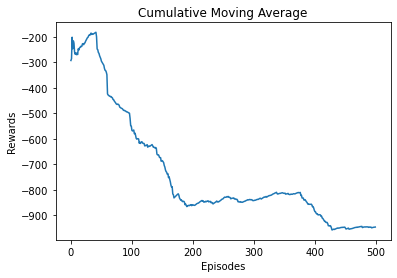

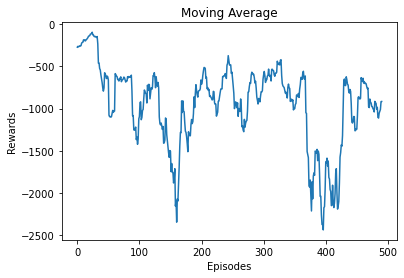

In [18]:
# cumulative moving average
plot_cma(episode_durations, "Duration")
plot_cma(episode_rewards, "Rewards")
# moving average
reward_ma(episode_rewards,10,True)

#### Double DQN - Begin Training
Uses Experience Replay and two Neural Networks (Policy Network and Target Network) to calculate current state's Q-Values and next state's Q-Values. Target Network's weights are updated every 10 episodes, using Policy Network's weights. Double DQN helps us reduce the overestimation of Q-Values and helps us train faster and have more stable learning.

In [19]:
# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(target_net, next_states) # get Q-Values for next state from target net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            episode_durations.append(timestep) # append episode duration
            episode_rewards.append(r_metric) # append episode rewards
            break
    
    # update target network weights
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict()) # copy policy network's weights to target network

    # check if agent solved the game   
    #if reward_ma(episode_rewards,100,False) >= 200:
       # break

# close the render window        
#env.close()

#### Plot Performance Metrics

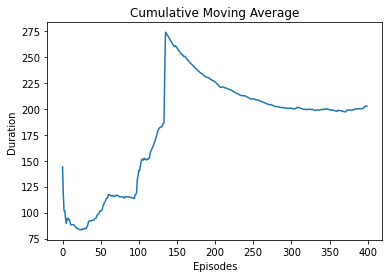

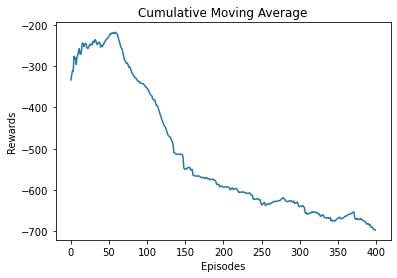

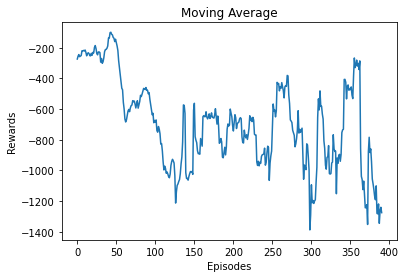

In [14]:
# cumulative moving average
plot_cma(episode_durations, "Duration")
plot_cma(episode_rewards, "Rewards")
# moving average
reward_ma(episode_rewards,10,True)

#### Dueling DQN - Begin Training
Uses experience replay and two streams inside the Neural Network: One that estimates the state value V(s), which is the value of being at state s and one that estimates the advantage for each action A(s,a), which is the advantage of taking the action a at state s. In the end, those two streams are combined through a special aggregation to get an estimate of the Q-Value Q(s,a).

In [6]:
# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, duel_policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(duel_policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(duel_policy_net, next_states) # get Q-Values for next state from policy net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            episode_durations.append(timestep) # append episode duration
            episode_rewards.append(r_metric) # append episode rewards
            break

    # check if agent solved the game   
    #if reward_ma(episode_rewards,100,False) >= 200:
       # break

# close the render window        
#env.close()

#### Plot Performance Metrics

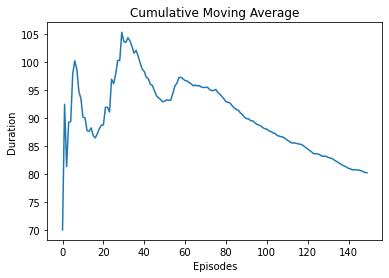

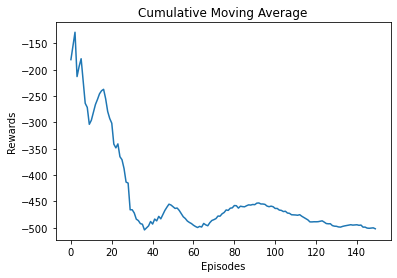

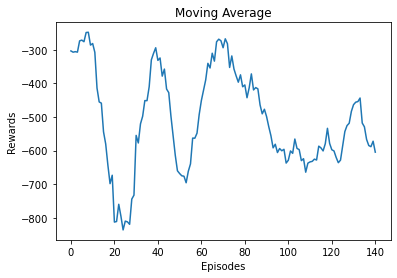

In [9]:
# cumulative moving average
plot_cma(episode_durations, "Duration")
plot_cma(episode_rewards, "Rewards")
# moving average
reward_ma(episode_rewards,10,True)

#### Dueling Double DQN - Begin Training
Uses experience replay, two Neural Networks (Policy Network and Target Network) to calculate current state's Q-Values and next state's Q-Values and two streams inside the Neural Networks: One that estimates the state value V(s), which is the value of being at state s and one that estimates the advantage for each action A(s,a), which is the advantage of taking the action a at state s. In the end, those two streams are combined through a special aggregation to get an estimate of the Q-Value Q(s,a).

In [7]:
# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, duel_policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(duel_policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(duel_target_net, next_states) # get Q-Values for next state from target net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            duel_optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            duel_optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            episode_durations.append(timestep) # append episode duration
            episode_rewards.append(r_metric) # append episode rewards
            break
    
    # update target network weights
    if episode % target_update == 0:
        duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy policy network's weights to target network

    # check if agent solved the game   
    #if reward_ma(episode_rewards,100,False) >= 200:
       # break

# close the render window        
#env.close()

#### Plot Performance Metrics

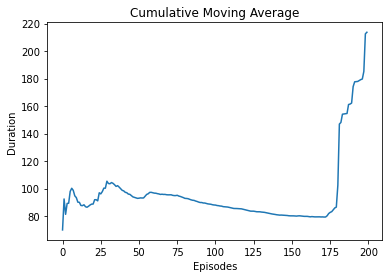

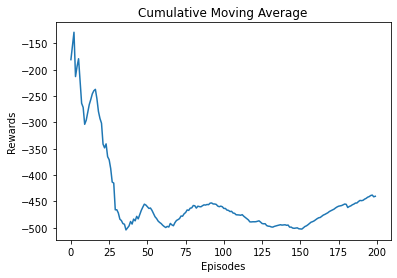

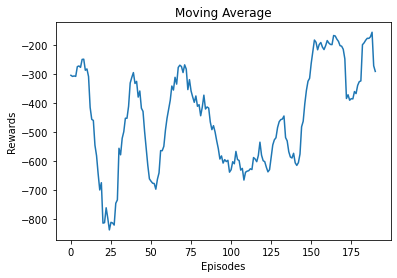

In [11]:
# cumulative moving average
plot_cma(episode_durations, "Duration")
plot_cma(episode_rewards, "Rewards")
# moving average
reward_ma(episode_rewards,10,True)

#### Testing the models' hyperparameters

##### Vanilla DQN

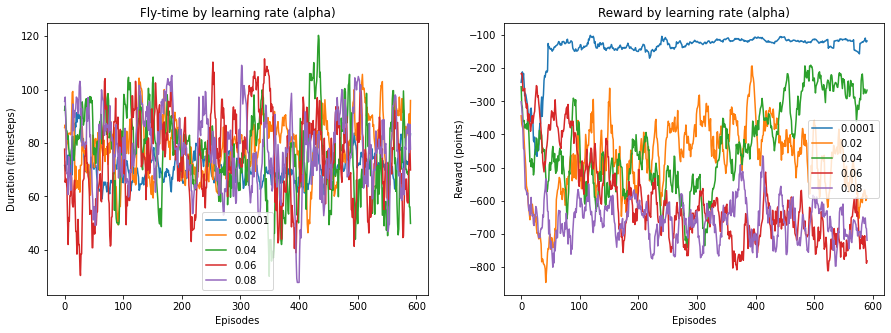

In [123]:

# Set device based on wether there is a GPU or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.001
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 600

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0] = fig.add_subplot()
# ax[1] = fig.add_subplot()

# Begin training our agent on the selected gaming environment
for lr in np.arange(0.0001, 0.1, 0.02):
    env_name = 'LunarLander-v2'
    env = EnvManager(env_name, device) # load the environment manager helper
    agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer
    
    training_duration = [] # initialize/Reset duration of each episode
    training_rewards = [] # initialize/Reset rewards of each episode

    for episode in range(num_episodes):
        r_metric = 0 # initialize/Reset reward metric
        duration = 0 # initialize/Reset duration metric
        env.reset() # reset the environment on each episode
        state = env.get_state() # get current (initial) state

        # run timesteps until state is terminal
        for timestep in count():
            #env.render() # render the game image
            action = agent.select_action(state, policy_net) # select an action with epsilon greedy
            reward = env.take_action(action).float() # get the selected action's reward
            r_metric += reward.item() # sum the reward
            next_state = env.get_state() # get the new state
            memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
            state = next_state # set new state as current state

            # check if there are enough experiences in the memory to sample
            if memory.batch_available(batch_size):
                experiences = memory.get(batch_size) # get a batch of experiences
                states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
                # Neural Network part
                current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
                next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
                target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
                # Back propagation
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
                optimizer.zero_grad() # reset gradients (required by PyTorch)
                loss.backward() # back propagate loss
                optimizer.step() # update weights
            
            # check if last action ended the episode    
            if env.done:
                duration += timestep
                # training_duration.append(timestep) # append episode duration
                # training_rewards.append(r_metric) # append episode rewards
                break
            if timestep == 150:
                break
    
        training_duration.append(duration) # append training duration
        training_rewards.append(r_metric)  # append training rewards

    # 10 episodes duration moving average 
    dur = np.cumsum(training_duration, dtype=float)
    dur[10:] = dur[10:] - dur[:-10]
    training_duration_average =  dur[10 - 1:] / 10
    # 10 episodes reward moving average 
    rew = np.cumsum(training_rewards, dtype=float)
    rew[10:] = rew[10:] - rew[:-10]
    training_rewards_average =  rew[10 - 1:] / 10
    
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Duration (timesteps)')
    ax[0].set_title('Fly-time by learning rate (alpha)')
    ax[0].plot(np.arange(len(training_duration_average)), training_duration_average, label = '{:.2}'.format(lr))
    ax[0].legend()
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Reward (points)')
    ax[1].set_title('Reward by learning rate (alpha)')
    ax[1].plot(np.arange(len(training_rewards_average)), training_rewards_average, label = '{:.2}'.format(lr))
    ax[1].legend()

  

#### Testing the epsilon decay rate

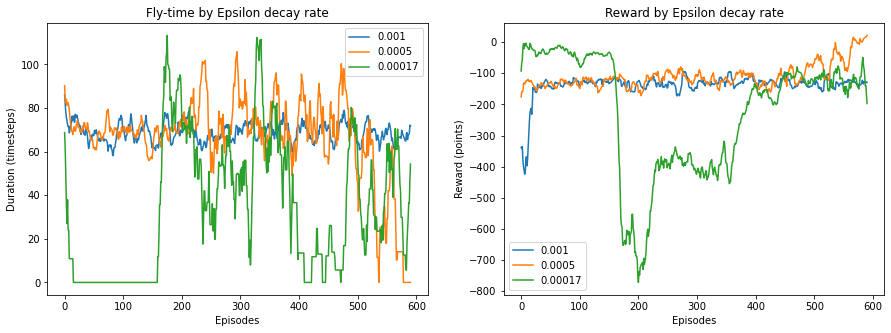

In [139]:
# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.001
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 600

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0] = fig.add_subplot()
# ax[1] = fig.add_subplot()

# Begin training our agent on the selected gaming environment
for epsilon_decay_rate in [0.001, 0.0005, 0.00017]:
    env_name = 'LunarLander-v2'
    env = EnvManager(env_name, device) # load the environment manager helper
    agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer
    
    training_duration = [] # initialize/Reset duration of each episode
    training_rewards = [] # initialize/Reset rewards of each episode

    for episode in range(num_episodes):
        r_metric = 0 # initialize/Reset reward metric
        duration = 0 # initialize/Reset duration metric
        env.reset() # reset the environment on each episode
        state = env.get_state() # get current (initial) state

        # run timesteps until state is terminal
        for timestep in count():
            #env.render() # render the game image
            action = agent.select_action(state, policy_net) # select an action with epsilon greedy
            reward = env.take_action(action).float() # get the selected action's reward
            r_metric += reward.item() # sum the reward
            next_state = env.get_state() # get the new state
            memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
            state = next_state # set new state as current state

            # check if there are enough experiences in the memory to sample
            if memory.batch_available(batch_size):
                experiences = memory.get(batch_size) # get a batch of experiences
                states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
                # Neural Network part
                current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
                next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
                target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
                # Back propagation
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
                optimizer.zero_grad() # reset gradients (required by PyTorch)
                loss.backward() # back propagate loss
                optimizer.step() # update weights
            
            # check if last action ended the episode    
            if env.done:
                duration += timestep
                # training_duration.append(timestep) # append episode duration
                # training_rewards.append(r_metric) # append episode rewards
                break
            if timestep == 150:
                break
    
        training_duration.append(duration) # append training duration
        training_rewards.append(r_metric)  # append training rewards

    # 10 episodes duration moving average 
    dur = np.cumsum(training_duration, dtype=float)
    dur[10:] = dur[10:] - dur[:-10]
    training_duration_average =  dur[10 - 1:] / 10
    # 10 episodes reward moving average 
    rew = np.cumsum(training_rewards, dtype=float)
    rew[10:] = rew[10:] - rew[:-10]
    training_rewards_average =  rew[10 - 1:] / 10
    
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Duration (timesteps)')
    ax[0].set_title('Fly-time by Epsilon decay rate')
    ax[0].plot(np.arange(len(training_duration_average)), training_duration_average, label = '{:.2}'.format(epsilon_decay_rate))
    ax[0].legend()
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Reward (points)')
    ax[1].set_title('Reward by Epsilon decay rate')
    ax[1].plot(np.arange(len(training_rewards_average)), training_rewards_average, label = '{:.2}'.format(epsilon_decay_rate))
    ax[1].legend()

#### Testing the number of hidden neurons

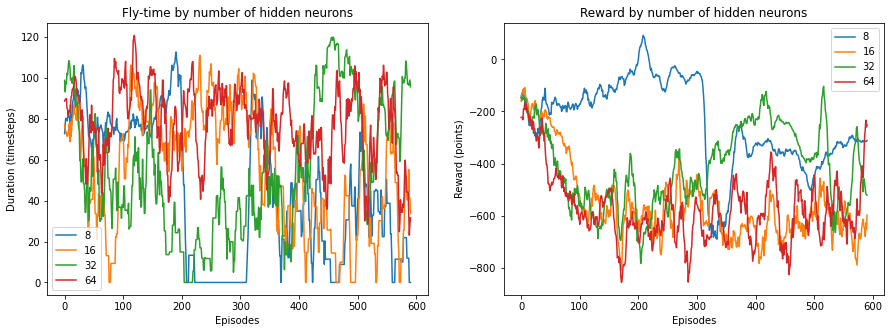

In [132]:
# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 600

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0] = fig.add_subplot()
# ax[1] = fig.add_subplot()

# Begin training our agent on the selected gaming environment
for hidden_neurons in [8, 16, 32, 64]:
    env_name = 'LunarLander-v2'
    env = EnvManager(env_name, device) # load the environment manager helper
    agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer
    
    training_duration = [] # initialize/Reset duration of each episode
    training_rewards = [] # initialize/Reset rewards of each episode

    for episode in range(num_episodes):
        r_metric = 0 # initialize/Reset reward metric
        duration = 0 # initialize/Reset duration metric
        env.reset() # reset the environment on each episode
        state = env.get_state() # get current (initial) state

        # run timesteps until state is terminal
        for timestep in count():
            #env.render() # render the game image
            action = agent.select_action(state, policy_net) # select an action with epsilon greedy
            reward = env.take_action(action).float() # get the selected action's reward
            r_metric += reward.item() # sum the reward
            next_state = env.get_state() # get the new state
            memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
            state = next_state # set new state as current state

            # check if there are enough experiences in the memory to sample
            if memory.batch_available(batch_size):
                experiences = memory.get(batch_size) # get a batch of experiences
                states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
                # Neural Network part
                current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
                next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
                target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
                # Back propagation
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
                optimizer.zero_grad() # reset gradients (required by PyTorch)
                loss.backward() # back propagate loss
                optimizer.step() # update weights
            
            # check if last action ended the episode    
            if env.done:
                duration += timestep
                # training_duration.append(timestep) # append episode duration
                # training_rewards.append(r_metric) # append episode rewards
                break
            if timestep == 150:
                break
    
        training_duration.append(duration) # append training duration
        training_rewards.append(r_metric)  # append training rewards

    # 10 episodes duration moving average 
    dur = np.cumsum(training_duration, dtype=float)
    dur[10:] = dur[10:] - dur[:-10]
    training_duration_average =  dur[10 - 1:] / 10
    # 10 episodes reward moving average 
    rew = np.cumsum(training_rewards, dtype=float)
    rew[10:] = rew[10:] - rew[:-10]
    training_rewards_average =  rew[10 - 1:] / 10
    
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Duration (timesteps)')
    ax[0].set_title('Fly-time by number of hidden neurons')
    ax[0].plot(np.arange(len(training_duration_average)), training_duration_average, label = '{}'.format(hidden_neurons))
    ax[0].legend()
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Reward (points)')
    ax[1].set_title('Reward by number of hidden neurons')
    ax[1].plot(np.arange(len(training_rewards_average)), training_rewards_average, label = '{}'.format(hidden_neurons))
    ax[1].legend()

#### Testing the discount rate (gamma)

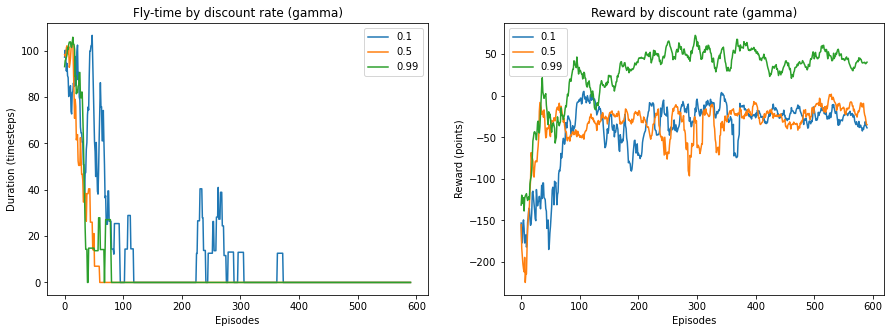

In [133]:
# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 600

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0] = fig.add_subplot()
# ax[1] = fig.add_subplot()

# Begin training our agent on the selected gaming environment
for gamma in [0.1, 0.5, 0.99]:
    env_name = 'LunarLander-v2'
    env = EnvManager(env_name, device) # load the environment manager helper
    agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer
    
    training_duration = [] # initialize/Reset duration of each episode
    training_rewards = [] # initialize/Reset rewards of each episode

    for episode in range(num_episodes):
        r_metric = 0 # initialize/Reset reward metric
        duration = 0 # initialize/Reset duration metric
        env.reset() # reset the environment on each episode
        state = env.get_state() # get current (initial) state

        # run timesteps until state is terminal
        for timestep in count():
            #env.render() # render the game image
            action = agent.select_action(state, policy_net) # select an action with epsilon greedy
            reward = env.take_action(action).float() # get the selected action's reward
            r_metric += reward.item() # sum the reward
            next_state = env.get_state() # get the new state
            memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
            state = next_state # set new state as current state

            # check if there are enough experiences in the memory to sample
            if memory.batch_available(batch_size):
                experiences = memory.get(batch_size) # get a batch of experiences
                states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
                # Neural Network part
                current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
                next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
                target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
                # Back propagation
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
                optimizer.zero_grad() # reset gradients (required by PyTorch)
                loss.backward() # back propagate loss
                optimizer.step() # update weights
            
            # check if last action ended the episode    
            if env.done:
                duration += timestep
                # training_duration.append(timestep) # append episode duration
                # training_rewards.append(r_metric) # append episode rewards
                break
            if timestep == 150:
                break
    
        training_duration.append(duration) # append training duration
        training_rewards.append(r_metric)  # append training rewards

    # 10 episodes duration moving average 
    dur = np.cumsum(training_duration, dtype=float)
    dur[10:] = dur[10:] - dur[:-10]
    training_duration_average =  dur[10 - 1:] / 10
    # 10 episodes reward moving average 
    rew = np.cumsum(training_rewards, dtype=float)
    rew[10:] = rew[10:] - rew[:-10]
    training_rewards_average =  rew[10 - 1:] / 10
    
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Duration (timesteps)')
    ax[0].set_title('Fly-time by discount rate (gamma)')
    ax[0].plot(np.arange(len(training_duration_average)), training_duration_average, label = '{}'.format(gamma))
    ax[0].legend()
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Reward (points)')
    ax[1].set_title('Reward by discount rate (gamma)')
    ax[1].plot(np.arange(len(training_rewards_average)), training_rewards_average, label = '{}'.format(gamma))
    ax[1].legend()

#### Final training and testing 

In the next sections the models are re-trained one at the time (with the chosen hyperparamters) and finally tested. For each model there is a first cell where all the parameters are re-initiated, and a second cell where the model is trained (and its outputs stored in lists). 

In [21]:
#INITIALISE VANILLA-DQN WITH ALL OPTIMIZED HYPERPARAMETERS

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 1000

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Begin training our agent on the selected gaming environment

# Create the Deep Reinforcement Learning agent
agent = DRLAgent(strategy, env.num_actions_available(), device)

# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Create the target network for Double Deep Q-Network
target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for next state's Q-Values
target_net.load_state_dict(policy_net.state_dict()) # copy policy's net parameters to target net
target_net.eval() # set target net to eval so it's weights do not update with back propagation

# choose the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

# Create the Dueling Deep Q-Network
duel_policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for current state's Q-Values
# Create the target network for Dueling Double Deep Q-Network
duel_target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for next state's Q-Values
duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy dueling policy's net parameters to dueling target net
duel_target_net.eval() # set dueling target net to eval so it's weights do not update with back propagation

# choose the optimizer
duel_optimizer = optim.Adam(params=duel_policy_net.parameters(), lr=lr) # Adam optimizer




In [22]:
# TRAIN VANILLA DQN

env_name = 'LunarLander-v2'
env = EnvManager(env_name, device) # load the environment manager helper
agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

vanilla_episode_durations = [] # variable to store the duration of each episode
vanilla_episode_rewards = [] # variable to store rewards of each episode

# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(policy_net, next_states) # get Q-Values for next state from policy net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            vanilla_episode_durations.append(timestep) # append episode duration
            vanilla_episode_rewards.append(r_metric) # append episode rewards
            break

        if timestep == 500:
            vanilla_episode_durations.append(timestep) # append episode duration
            vanilla_episode_rewards.append(r_metric) # append episode rewards
            break


# 10 episodes duration moving average 
dur = np.cumsum(vanilla_episode_durations, dtype=float)
dur[10:] = dur[10:] - dur[:-10]
vanilla_training_duration_average =  dur[10 - 1:] / 10
# 10 episodes reward moving average 
rew = np.cumsum(vanilla_episode_rewards, dtype=float)
rew[10:] = rew[10:] - rew[:-10]
vanilla_training_rewards_average =  rew[10 - 1:] / 10

In [24]:
#INITIALISE DOUBLE DQN WITH ALL OPTIMIZED HYPERPARAMETERS

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 1000

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Begin training our agent on the selected gaming environment

# Create the Deep Reinforcement Learning agent
agent = DRLAgent(strategy, env.num_actions_available(), device)

# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Create the target network for Double Deep Q-Network
target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for next state's Q-Values
target_net.load_state_dict(policy_net.state_dict()) # copy policy's net parameters to target net
target_net.eval() # set target net to eval so it's weights do not update with back propagation

# choose the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

# Create the Dueling Deep Q-Network
duel_policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for current state's Q-Values
# Create the target network for Dueling Double Deep Q-Network
duel_target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for next state's Q-Values
duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy dueling policy's net parameters to dueling target net
duel_target_net.eval() # set dueling target net to eval so it's weights do not update with back propagation

# choose the optimizer
duel_optimizer = optim.Adam(params=duel_policy_net.parameters(), lr=lr) # Adam optimizer

In [25]:
# TRAIN DOUBLE DQN

env_name = 'LunarLander-v2'
env = EnvManager(env_name, device) # load the environment manager helper
agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

double_episode_durations = [] # variable to store the duration of each episode
double_episode_rewards = [] # variable to store rewards of each episode

# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(target_net, next_states) # get Q-Values for next state from target net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            double_episode_durations.append(timestep) # append episode duration
            double_episode_rewards.append(r_metric) # append episode rewards
            break
        
        if timestep == 500:
            double_episode_durations.append(timestep) # append episode duration
            double_episode_rewards.append(r_metric) # append episode rewards
            break
    
    # update target network weights
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict()) # copy policy network's weights to target network


# 10 episodes duration moving average 
dur = np.cumsum(double_episode_durations, dtype=float)
dur[10:] = dur[10:] - dur[:-10]
double_training_duration_average =  dur[10 - 1:] / 10
# 10 episodes reward moving average 
rew = np.cumsum(double_episode_rewards, dtype=float)
rew[10:] = rew[10:] - rew[:-10]
double_training_rewards_average =  rew[10 - 1:] / 10

In [18]:
#INITIALISE DUELING-DQN WITH ALL OPTIMIZED HYPERPARAMETERS

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 1000

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Begin training our agent on the selected gaming environment

# Create the Deep Reinforcement Learning agent
agent = DRLAgent(strategy, env.num_actions_available(), device)

# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Create the target network for Double Deep Q-Network
target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for next state's Q-Values
target_net.load_state_dict(policy_net.state_dict()) # copy policy's net parameters to target net
target_net.eval() # set target net to eval so it's weights do not update with back propagation

# choose the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

# Create the Dueling Deep Q-Network
duel_policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for current state's Q-Values
# Create the target network for Dueling Double Deep Q-Network
duel_target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for next state's Q-Values
duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy dueling policy's net parameters to dueling target net
duel_target_net.eval() # set dueling target net to eval so it's weights do not update with back propagation

# choose the optimizer
duel_optimizer = optim.Adam(params=duel_policy_net.parameters(), lr=lr) # Adam optimizer


In [19]:
# TRAINING THE DUELING DQN

env_name = 'LunarLander-v2'
env = EnvManager(env_name, device) # load the environment manager helper
agent = DRLAgent(strategy, env.num_actions_available(), device) # Create the Deep Reinforcement Learning agent
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

dueling_episode_durations = [] # variable to store the duration of each episode
dueling_episode_rewards = [] # variable to store rewards of each episode

# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, duel_policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(duel_policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(duel_policy_net, next_states) # get Q-Values for next state from policy net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            dueling_episode_durations.append(timestep) # append episode duration
            dueling_episode_rewards.append(r_metric) # append episode rewards
            break

        if timestep == 500:
            dueling_episode_durations.append(timestep) # append episode duration
            dueling_episode_rewards.append(r_metric) # append episode rewards
            break
    
# 10 episodes duration moving average 
dur = np.cumsum(dueling_episode_durations, dtype=float)
dur[10:] = dur[10:] - dur[:-10]
dueling_training_duration_average =  dur[10 - 1:] / 10
# 10 episodes reward moving average 
rew = np.cumsum(dueling_episode_rewards, dtype=float)
rew[10:] = rew[10:] - rew[:-10]
dueling_training_rewards_average =  rew[10 - 1:] / 10

In [9]:
#INITIALISE DUELING DOUBLE WITH ALL OPTIMIZED HYPERPARAMETERS

# Parameters for Epsilon Greedy Strategy
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay_rate = 0.00017
strategy = EpsilonGreedyValue(max_epsilon, min_epsilon, epsilon_decay_rate)

# Parameters that control the Deep Q-Learning
gamma = 0.999
lr = 0.0001
num_episodes = 1000

# Parameters for Replay Memory
memory_size = 100000
batch_size = 256
memory = ReplayMemory(memory_size)

# Parameters for the architecture of the NN
hidden_neurons = 32 # number of neurons on the hidden layers
n_actions = env.env.action_space.n # for nn output, the number of actions
target_update = 10 # target nn weights update every n episodes
# Parameters for performance metrics
# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Begin training our agent on the selected gaming environment

# Create the Deep Reinforcement Learning agent
agent = DRLAgent(strategy, env.num_actions_available(), device)

# Create the Deep Q-Network
policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for current state's Q-Values

# Create the target network for Double Deep Q-Network
target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,False).to(device) # DQN for next state's Q-Values
target_net.load_state_dict(policy_net.state_dict()) # copy policy's net parameters to target net
target_net.eval() # set target net to eval so it's weights do not update with back propagation

# choose the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Adam optimizer

# Create the Dueling Deep Q-Network
duel_policy_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for current state's Q-Values
# Create the target network for Dueling Double Deep Q-Network
duel_target_net = DQN(env.n_state_features(),hidden_neurons,n_actions,True).to(device) # Dueling DQN for next state's Q-Values
duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy dueling policy's net parameters to dueling target net
duel_target_net.eval() # set dueling target net to eval so it's weights do not update with back propagation

# choose the optimizer
duel_optimizer = optim.Adam(params=duel_policy_net.parameters(), lr=lr) # Adam optimizer

In [10]:
#TRAINING THE DUELING DOUBLE

dueling_double_episode_durations = [] # variable to store the duration of each episode
dueling_double_episode_rewards = [] # variable to store rewards of each episode

# Begin training our agent on the selected gaming environment
for episode in range(num_episodes):
    env.reset() # reset the environment on each episode
    state = env.get_state() # get current (initial) state
    
    r_metric = 0 # initialize/Reset reward metric

    # run timesteps until state is terminal
    for timestep in count():
        #env.render() # render the game image
        action = agent.select_action(state, duel_policy_net) # select an action with epsilon greedy
        reward = env.take_action(action).float() # get the selected action's reward
        r_metric += reward.item() # sum the reward
        next_state = env.get_state() # get the new state
        memory.store(Experience(state, action, next_state, reward)) # store agent's experience 
        state = next_state # set new state as current state

        # check if there are enough experiences in the memory to sample
        if memory.batch_available(batch_size):
            experiences = memory.get(batch_size) # get a batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # convert to tensors for the neural networks
            # Neural Network part
            current_q_values = QValues.get_current(duel_policy_net, states, actions) # get Q-Values for current state from policy net
            next_q_values = QValues.get_next(duel_target_net, next_states) # get Q-Values for next state from target net
            target_q_values = (next_q_values * gamma) + rewards # calculate the target Q-Values to use for back propagation
            # Back propagation
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calculate the loss
            duel_optimizer.zero_grad() # reset gradients (required by PyTorch)
            loss.backward() # back propagate loss
            duel_optimizer.step() # update weights
        
        # check if last action ended the episode    
        if env.done:
            dueling_double_episode_durations.append(timestep) # append episode duration
            dueling_double_episode_rewards.append(r_metric) # append episode rewards
            break

        if timestep == 500:
            dueling_double_episode_durations.append(timestep) # append episode duration
            dueling_double_episode_rewards.append(r_metric) # append episode rewards
            break
    
    # update target network weights
    if episode % target_update == 0:
        duel_target_net.load_state_dict(duel_policy_net.state_dict()) # copy policy network's weights to target network

# 10 episodes duration moving average 
dur = np.cumsum(dueling_double_episode_durations, dtype=float)
dur[10:] = dur[10:] - dur[:-10]
dueling_double_training_duration_average =  dur[10 - 1:] / 10
# 10 episodes reward moving average 
rew = np.cumsum(dueling_double_episode_rewards, dtype=float)
rew[10:] = rew[10:] - rew[:-10]
dueling_double_training_rewards_average =  rew[10 - 1:] / 10

#### Plotting the results 

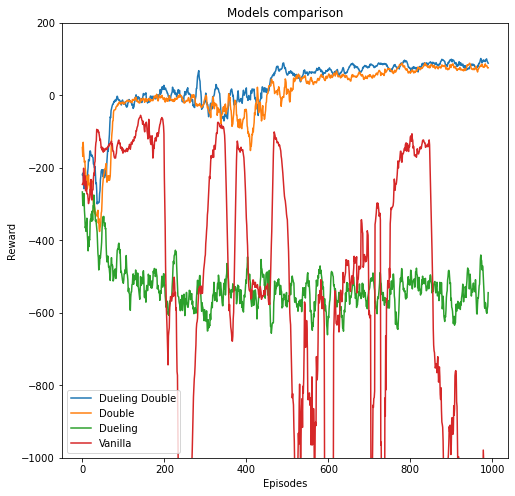

In [52]:
# plot the 10 episode rolling average reward of each model

fig = plt.subplots(figsize = (8,8))
plt.title('Models comparison')
plt.xlabel('Episodes')
plt.ylim(-1000,200)
plt.ylabel('Reward')
plt.plot(np.arange(len(dueling_double_training_rewards_average)), dueling_double_training_rewards_average, label = 'Dueling Double')
plt.plot(np.arange(len(double_training_rewards_average)), double_training_rewards_average, label = 'Double')
plt.plot(np.arange(len(dueling_training_rewards_average)), dueling_training_rewards_average, label = 'Dueling')
plt.plot(np.arange(len(vanilla_training_rewards_average)), vanilla_training_rewards_average, label = 'Vanilla')
plt.legend();

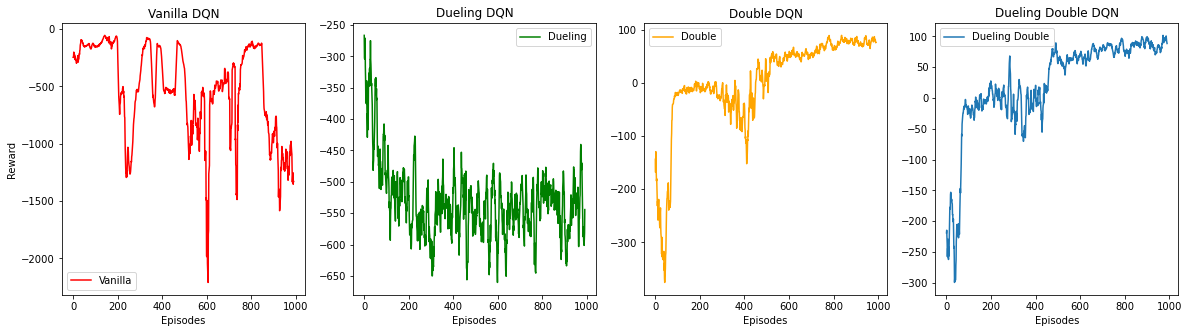

In [37]:
# plot the models' results, separately

fig, ax = plt.subplots(1,4, figsize = (20,5))
ax[0].plot(np.arange(len(vanilla_training_rewards_average)), vanilla_training_rewards_average, label = 'Vanilla', c = 'red')
ax[0].legend()
ax[0].set_title('Vanilla DQN')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Reward')
ax[1].plot(np.arange(len(dueling_training_rewards_average)), dueling_training_rewards_average, label = 'Dueling', c = 'green')
ax[1].legend()
ax[1].set_title('Dueling DQN')
ax[1].set_xlabel('Episodes')
ax[2].plot(np.arange(len(double_training_rewards_average)), double_training_rewards_average, label = 'Double', c = 'orange')
ax[2].legend()
ax[2].set_title('Double DQN')
ax[2].set_xlabel('Episodes')
ax[3].plot(np.arange(len(dueling_double_training_rewards_average)), dueling_double_training_rewards_average, label = 'Dueling Double')
ax[3].legend()
ax[3].set_title('Dueling Double DQN')
ax[3].set_xlabel('Episodes');

#### Metrics 

In [66]:
# rewards and timesteps averages for each model

print('Vanilla: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(vanilla_episode_durations), np.min(vanilla_episode_durations), np.max(vanilla_episode_durations)))
print('Vanilla: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(vanilla_episode_rewards), np.min(vanilla_episode_rewards), np.max(vanilla_episode_rewards)))
print('Dueling: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(dueling_episode_durations), np.min(dueling_episode_durations), np.max(dueling_episode_durations)))
print('Dueling: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(dueling_episode_rewards), np.min(dueling_episode_rewards), np.max(dueling_episode_rewards)))
print('Double: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(double_episode_durations), np.min(double_episode_durations), np.max(double_episode_durations)))
print('Double: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(double_episode_rewards), np.min(double_episode_rewards), np.max(double_episode_rewards)))
print('Dueling Double: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(dueling_double_episode_durations), np.min(dueling_double_episode_durations), np.max(dueling_double_episode_durations)))
print('Dueling Double: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(dueling_double_episode_rewards), np.min(dueling_double_episode_rewards), np.max(dueling_double_episode_rewards)))

Vanilla: mean episode duration = 253.675 | min episode duration = 49 | max episode duration = 500
Vanilla: mean reward = -527.4211718478566 | min reward = -6448.277877458371 | max reward = 239.5725368415824
Dueling: mean episode duration = 67.214 | min episode duration = 46 | max episode duration = 137
Dueling: mean reward = -528.8123826997648 | min reward = -1129.3000551462173 | max reward = -61.28033232362941
Double: mean episode duration = 456.424 | min episode duration = 65 | max episode duration = 500
Double: mean reward = 1.7109668719920774 | min reward = -597.8412189818919 | max reward = 128.45568719971925
Dueling Double: mean episode duration = 464.202 | min episode duration = 57 | max episode duration = 500
Dueling Double: mean reward = 22.974367201545558 | min reward = -485.236411975231 | max reward = 227.0166863068007


In [68]:
# rewards and timesteps 10 episodes rolling averages for each model
print('Vanilla: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(vanilla_training_duration_average), np.min(vanilla_training_duration_average), np.max(vanilla_training_duration_average)))
print('Vanilla: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(vanilla_training_rewards_average), np.min(vanilla_training_rewards_average), np.max(vanilla_training_rewards_average)))
print('Dueling: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(dueling_training_duration_average), np.min(dueling_training_duration_average), np.max(dueling_training_duration_average)))
print('Dueling: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(dueling_training_rewards_average), np.min(dueling_training_rewards_average), np.max(dueling_training_rewards_average)))
print('Double: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(double_training_duration_average), np.min(double_training_duration_average), np.max(double_training_duration_average)))
print('Double: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(double_training_rewards_average), np.min(double_training_rewards_average), np.max(double_training_rewards_average)))
print('Dueling Double: mean episode duration = {} | min episode duration = {} | max episode duration = {}'.format(np.mean(dueling_double_training_duration_average), np.min(dueling_double_training_duration_average), np.max(dueling_double_training_duration_average)))
print('Dueling Double: mean reward = {} | min reward = {} | max reward = {}'.format(np.mean(dueling_double_training_rewards_average), np.min(dueling_double_training_rewards_average), np.max(dueling_double_training_rewards_average)))

Vanilla: mean episode duration = 254.39182643794146 | min episode duration = 65.9 | max episode duration = 500.0
Vanilla: mean reward = -525.3551800246779 | min reward = -2208.742346156994 | max reward = -54.9341601362903
Dueling: mean episode duration = 67.08435923309789 | min episode duration = 57.0 | max episode duration = 100.5
Dueling: mean reward = -530.5758897486406 | min reward = -660.4861410105601 | max reward = -266.4408089472912
Double: mean episode duration = 457.83148335015136 | min episode duration = 100.4 | max episode duration = 500.0
Double: mean reward = 2.0992352925827658 | min reward = -375.5150165274739 | max reward = 89.39634154002415
Dueling Double: mean episode duration = 465.72653884964683 | min episode duration = 85.3 | max episode duration = 500.0
Dueling Double: mean reward = 23.77182850561909 | min reward = -299.40705822137534 | max reward = 101.8286828314449
